In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import json

from tqdm.notebook import tqdm

from collections import defaultdict
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
import pickle

def get_path(filename):
  return f'/content/drive/MyDrive/Data/{filename}'

def get_data_from_pickle(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

def write_data_to_pickle(data, path):
  with open(path, "wb") as f:
      f.write(pickle.dumps(data))

In [ ]:
tag_vectors = get_data_from_pickle(get_path('tag_vectors'))
cluster_centers = get_data_from_pickle(get_path('kmeans15.cluster_centers_.pickle'))
unique_tag_list = get_data_from_pickle(get_path('unique_tag_list.pickle'))
tag_dict = get_data_from_pickle(get_path('tag_dict.pickle'))

tag_matrix = np.array(tag_vectors)

df_meta = pd.read_csv(get_path('Meta_v1.csv'))
# df = pd.read_json(get_path('data_version_2.json'))

In [ ]:
df_train = pd.read_csv(get_path('train_v7.csv'))
df_test = pd.read_csv(get_path('test_v7.csv'))

In [ ]:
tag_dict[8]

['연말',
 '추위',
 '행복',
 '눈',
 '따뜻함',
 '12월',
 '추운',
 '눈오는날',
 '크리스마스캐롤',
 '성탄절',
 '첫눈',
 '쌀쌀한',
 '캐롤',
 '메리크리스마스',
 '따뜻',
 '겨울밤',
 '겨울노래',
 '겨울',
 '따스함',
 '따듯한',
 '따뜻한',
 '따스한',
 '찬바람',
 'Christmas',
 '크리스마스',
 '겨울감성',
 '가족',
 '캐럴',
 '크리스마스노래',
 '로멘틱',
 '선물']

In [ ]:
tag2idx = {tag: i for i, tag in enumerate(unique_tag_list)}
idx2tag = {i: tag for i, tag in enumerate(unique_tag_list)}

# df = df.reset_index(drop=True)

# unique_songs = list(set([song for songs in df.songs2 for song in songs]))

# song_idx2new_idx = {song_id: idx for idx, song_id in enumerate(unique_songs)}
# new_idx2song_idx = {idx: song_id for idx, song_id in enumerate(unique_songs)}

# genres_set = list(set([genre for genres in df_meta.gnrs for genre in genres]))

# df_meta['new_id'] = df_meta.id.map(lambda x: song_idx2new_idx.get(int(x)))

In [ ]:
df_train

,tag_id,song_id,freq,freq2
0,561,543027,1.0,0.5
1,1142,281511,1.0,0.5
2,774,90766,1.0,0.5
3,863,54894,3.0,1.0
4,113,111779,4.0,1.0
...,...,...,...,...
1221439,777,585866,1.0,0.5
1221440,611,300742,1.0,0.5
1221441,777,137882,1.0,0.5
1221442,225,345984,1.0,0.5


In [ ]:
df_train[df_train.tag_id.map(lambda x: idx2tag.get(x)) == "성탄절"]

,tag_id,song_id,freq,freq2
1416,473,338900,1.0,0.5
3159,473,666451,1.0,0.5
5368,473,61771,4.0,1.0
9004,473,312381,1.0,0.5
9550,473,397351,1.0,0.5
...,...,...,...,...
1202186,473,332893,1.0,0.5
1203756,473,83577,1.0,0.5
1210394,473,262699,1.0,0.5
1211179,473,262202,1.0,0.5


In [ ]:
df_meta[df_meta.id == 338900]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,gnrs,new_id
33529,['GN0901'],20181105,Everyday Is Christmas (Deluxe),10107511,[54103],Candy Cane Lane,['GN0900'],['Sia'],338900,['POP'],42920


In [ ]:
# df['tagIds'] = df.tags.map(lambda x: [tag2idx.get(tag) for tag in x])

tag_cluster_ids = [
    [tag2idx[tag] for tag in tag_dict[key]]
    for key in range(15)
]

# min_tag_count = 2

# df_clusters = [
#     df[df.tagIds.map(lambda x: np.intersect1d(tag_cluster_ids[key], x, assume_unique=True).shape[0] >= min_tag_count )]
#     for key in range(15)
# ]

# cluster_songs = []

# for key in range(15):
#     cluster_songs.append(list(set([song for songs in df_clusters[key].songs2 for song in songs])))
#     print(f"{key} : {df_clusters[key].shape} / {len(cluster_songs[key])}")

In [ ]:
def get_recommendation_model(tag_num, music_num, embedding_matrix, latent_features=10, trainable=True):

  tag = Input(shape=(1,), dtype='int32')
  item = Input(shape=(1,), dtype='int32')

  # User embedding for GMF

  gmf_tag_embedding = Embedding(
            embedding_matrix.shape[0],
            embedding_matrix.shape[1],
            input_length=1,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=trainable,
            name='tag_embedding'
        )(tag)
  
  # gmf_tag_embedding = Embedding(tag_num, latent_features, input_length=user.shape[1])(tag)
  gmf_tag_embedding = Flatten()(gmf_tag_embedding)

  # Item embedding for GMF
  gmf_item_embedding = Embedding(music_num, latent_features, input_length=item.shape[1])(item)
  gmf_item_embedding = Flatten()(gmf_item_embedding)

  # GMF layers
  gmf_mul =  Multiply()([gmf_tag_embedding, gmf_item_embedding])


  # User embedding for MLP
  mlp_tag_embedding = Embedding(
            embedding_matrix.shape[0],
            embedding_matrix.shape[1],
            input_length=1,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=trainable,
            name='tag_embedding2'
        )(tag)
  
  mlp_tag_embedding = Flatten()(mlp_tag_embedding)

  # Item embedding for MLP
  mlp_item_embedding = Embedding(music_num, 32, input_length=item.shape[1])(item)
  mlp_item_embedding = Flatten()(mlp_item_embedding)

  # MLP layers
  mlp_concat = Concatenate()([mlp_tag_embedding, mlp_item_embedding])
  mlp_dropout = Dropout(0.2)(mlp_concat)

  # Layer1
  mlp_layer_1 = Dense(units=64, activation='relu', name='mlp_layer1')(mlp_dropout)  # (64,1)
  mlp_dropout1 = Dropout(rate=0.2, name='dropout1')(mlp_layer_1)                    # (64,1)
  mlp_batch_norm1 = BatchNormalization(name='batch_norm1')(mlp_dropout1)            # (64,1)

  # Layer2
  mlp_layer_2 = Dense(units=32, activation='relu', name='mlp_layer2')(mlp_batch_norm1)  # (32,1)
  mlp_dropout2 = Dropout(rate=0.2, name='dropout2')(mlp_layer_2)                        # (32,1)
  mlp_batch_norm2 = BatchNormalization(name='batch_norm2')(mlp_dropout2)                # (32,1)

  # Layer3
  mlp_layer_3 = Dense(units=16, activation='relu', name='mlp_layer3')(mlp_batch_norm2)  # (16,1)

  # Layer4
  mlp_layer_4 = Dense(units=8, activation='relu', name='mlp_layer4')(mlp_layer_3)       # (8,1)



  # merge GMF + MLP
  merged_vector = tf.keras.layers.concatenate([gmf_mul, mlp_layer_4]) # (16)

  # Output layer
  output_layer = Dense(1, kernel_initializer='lecun_uniform', name='output_layer')(merged_vector) # 1,1 / h(8,1)초기화

  # Model
  model = Model([tag, item], output_layer)
  model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=["mse"])
  return model

In [ ]:
class AllTagClusterModel(object):
    
    def __init__(self, _df, tag2idx):
        self._df = _df
        
        self.tag2id = tag2idx
        self._max_tag_len = len(tag2idx.keys())
        self._unique_tag_list = list(tag2idx.keys())
        
        self._unique_songs = list(set([song for songs in _df.songs2 for song in songs]))
        self._song_idx2new_idx = {song_id: idx for idx, song_id in enumerate(self._unique_songs)}
        self._new_idx2song_idx = {idx: song_id for idx, song_id in enumerate(self._unique_songs)}
        self._max_song_len = len(self._unique_songs)
        
        self._df['_song_ids'] = _df.songs2.map(lambda x: [self._song_idx2new_idx.get(song) for song in x])
        
        
    def preprocess(self, test_size=0.2, NEG_SAMPLE_NUM=20):
        _tag_song_freq = {i: defaultdict(int) for i in range(self._max_tag_len)}
        
        for tags, songs in tqdm(zip(self._df.tagIds, self._df._song_ids)):
            for song in songs:
                for tag in tags:
                    _tag_song_freq[tag][song] += 1
                    
        _df_freq = pd.DataFrame(_tag_song_freq).T
        _df_freq = _df_freq.stack().reset_index()
        _df_freq.columns = ['tag_id', 'song_id', 'freq']
        
        neg_data = []
        
        for tag in tqdm(self._unique_tag_list):
            i = NEG_SAMPLE_NUM
            new_tag_id = self.tag2id[tag]
            while i:
                random_id = self.get_random_music_id(self._max_song_len)
                if not _tag_song_freq[new_tag_id][random_id]:
                    neg_data.append((new_tag_id, random_id, 0))
                    i -= 1
        
        _df_neg = pd.DataFrame(neg_data, columns=_df_freq.columns)
        _df_freq = pd.concat([_df_freq, _df_neg]).sample(frac=1).reset_index(drop=True)
        _df_freq['freq2'] = _df_freq.freq.map(lambda x: 0.5 if x == 1 else (0 if x == 0 else 1))

        _df_over = _df_freq[_df_freq.freq > 1]
        
        test = _df_over.groupby('tag_id').apply(lambda x: self.get_test_sample(x, test_size)).reset_index()
        self.test = test.sample(frac=1).reset_index(drop=True)
        
        self.train = _df_freq[~_df_freq.index.isin(self.test.level_1)]
        
        self.x_train = [ 
                        self.train.tag_id.values.reshape(-1,1),
                        self.train.song_id.values.reshape(-1,1)
                        ]
        self.y_train = self.train.freq2.values
        
        self.x_test = [ 
                       self.test.tag_id.values.reshape(-1,1),
                       self.test.song_id.values.reshape(-1,1)
                       ]
        self.y_test = self.test.freq2.values
        
        
        
    def build_model(self, tag_matrix, EMBEDDING_SIZE=10, trainable=True):
        self.model = get_recommendation_model(self._max_tag_len, self._max_song_len, tag_matrix, EMBEDDING_SIZE, trainable)
        
    def fit(self, batch_size=64, epochs=10):
        self.history = self.model.fit(
            x=self.x_train,
            y=self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(self.x_test, self.y_test),
        )
        
    def print_summary(self):
      print(self.model.summary())
        
    def predict(self, tag, k=50):
      _test_tag_id = self.tag2id.get(tag)

      if _test_tag_id == None: return []

      tags_input = np.array([_test_tag_id] * self._max_song_len).reshape(-1, 1)
      songs_input = np.array([*range(self._max_song_len)]).reshape(-1, 1)
      
      predicted = self.model.predict([tags_input, songs_input]).flatten()
      predicted = predicted.argsort()[-k:][::-1]

      return [self._new_idx2song_idx.get(new_id) for new_id in predicted]
        
    @staticmethod
    def get_test_sample(df, test_size=0.2, drop_column='tag_id'):
        return df.sample(frac=test_size).drop(drop_column, axis=1)
        
    @staticmethod
    def get_random_music_id(_max_len):
        return random.randint(0, _max_len-1)

In [ ]:
# train['song_id2'] = train.song_id.map(lambda x: all_tag_model._new_idx2song_idx[x])
# test['song_id2'] = test.song_id.map(lambda x: all_tag_model._new_idx2song_idx[x])

In [ ]:
train_clusters = [df_train[df_train.tag_id.isin(tag_cluster_ids[key])] for key in range(15)]

In [ ]:
for i, train_df in enumerate(train_clusters):
  print(f"{i} {train_df.shape} / song: {train_df.song_id.nunique()} tag: {train_df.tag_id.nunique()}")

0 (57972, 4) / song: 20555 tag: 54
1 (47934, 4) / song: 25221 tag: 286
2 (33666, 4) / song: 14329 tag: 35
3 (7149, 4) / song: 3553 tag: 26
4 (67939, 4) / song: 30099 tag: 178
5 (77976, 4) / song: 27710 tag: 148
6 (128633, 4) / song: 41330 tag: 87
7 (84746, 4) / song: 27237 tag: 59
8 (38080, 4) / song: 17198 tag: 31
9 (282379, 4) / song: 51232 tag: 138
10 (104839, 4) / song: 32576 tag: 100
11 (140968, 4) / song: 44154 tag: 92
12 (7636, 4) / song: 4635 tag: 15
13 (87454, 4) / song: 28336 tag: 80
14 (54073, 4) / song: 18956 tag: 53


In [ ]:
train_freq_clusters = []
for i in range(15):
  song_freq_cluster = train_clusters[i].song_id.value_counts()
  freq_song_ids = song_freq_cluster[song_freq_cluster > 3].index.values
  train_freq_clusters.append(train_clusters[i][train_clusters[i].song_id.isin(freq_song_ids)])
  print(f"{i}: {train_freq_clusters[i].shape} / {freq_song_ids.shape}")

0: (33283, 4) / (5095,)
1: (15498, 4) / (2615,)
2: (14764, 4) / (2467,)
3: (3268, 4) / (425,)
4: (28814, 4) / (4857,)
5: (45832, 4) / (6793,)
6: (73502, 4) / (11909,)
7: (49282, 4) / (6720,)
8: (16947, 4) / (2841,)
9: (236054, 4) / (25836,)
10: (67140, 4) / (9208,)
11: (87836, 4) / (13599,)
12: (1350, 4) / (253,)
13: (55414, 4) / (7369,)
14: (32534, 4) / (4309,)


In [ ]:
df_train

,tag_id,song_id,freq,freq2
0,561,543027,1.0,0.5
1,1142,281511,1.0,0.5
2,774,90766,1.0,0.5
3,863,54894,3.0,1.0
4,113,111779,4.0,1.0
...,...,...,...,...
1221439,777,585866,1.0,0.5
1221440,611,300742,1.0,0.5
1221441,777,137882,1.0,0.5
1221442,225,345984,1.0,0.5


In [ ]:
class ClusterModel(object):
    
    def __init__(self, train, tag2idx):
        self.song_freq_cluster = train.song_id.value_counts()
        self.freq_song_ids  = self.song_freq_cluster[self.song_freq_cluster > 2].index.values
        self.train = train[train.song_id.isin(self.freq_song_ids)]

        self.tag2id = tag2idx
        self._max_tag_len = len(tag2idx.keys())
        self._unique_tag_list = list(tag2idx.keys())
        
        self._unique_songs = self.freq_song_ids
        self._max_song_len = len(self._unique_songs)

        self._song_idx2new_idx = {song_id: idx for idx, song_id in enumerate(self._unique_songs)}
        self._new_idx2song_idx = {idx: song_id for idx, song_id in enumerate(self._unique_songs)}

        self.train['_song_id'] = self.train.song_id.map(lambda song_id: self._song_idx2new_idx.get(song_id))

        self.x_train = [ 
                        self.train.tag_id.values.reshape(-1,1),
                        self.train._song_id.values.reshape(-1,1)
                        ]
        
        self.y_train = self.train.freq2.values

    def build_model(self, tag_matrix, EMBEDDING_SIZE=10, trainable=True):
        self.model = get_recommendation_model(self._max_tag_len, self._max_song_len, tag_matrix, EMBEDDING_SIZE, trainable)
        
    def fit(self, batch_size=64, epochs=10):
        self.history = self.model.fit(
            x=self.x_train,
            y=self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1
        )
        
    def print_summary(self):
      print(self.model.summary())
        
    def predict(self, tag, k=50):
      _test_tag_id = self.tag2id.get(tag)

      if _test_tag_id == None: return []

      tags_input = np.array([_test_tag_id] * self._max_song_len).reshape(-1, 1)
      songs_input = np.array([*range(self._max_song_len)]).reshape(-1, 1)
      
      predicted = self.model.predict([tags_input, songs_input]).flatten()
      predicted = predicted.argsort()[-k:][::-1]

      return [self._new_idx2song_idx.get(new_id) for new_id in predicted]


In [ ]:
Clusters = [
    ClusterModel(train_freq_clusters[i], tag2idx)
    for i in range(15)
] 

In [ ]:
for i in range(15):
  Clusters[i].build_model(tag_matrix)

In [ ]:
for i in range(15):
  print(f"Model {i}")
  Clusters[i].fit()

Model 0
Epoch 1/10
521/521 [==============================] - 3s 6ms/step - loss: 0.8455 - mse: 0.0729
Epoch 2/10
521/521 [==============================] - 3s 7ms/step - loss: 0.7099 - mse: 0.0469
Epoch 3/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6872 - mse: 0.0375
Epoch 4/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6714 - mse: 0.0304
Epoch 5/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6596 - mse: 0.0258
Epoch 6/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6491 - mse: 0.0219
Epoch 7/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6396 - mse: 0.0192
Epoch 8/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6324 - mse: 0.0174
Epoch 9/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6261 - mse: 0.0164
Epoch 10/10
521/521 [==============================] - 3s 6ms/step - loss: 0.6200 - mse: 0.0160
Model 1
Epoch 1/10
243/243 [=============

In [ ]:
test_clusters = [df_test[df_test.tag_id.isin(tag_cluster_ids[key])] for key in range(15)]

In [ ]:
df_test[df_test.tag_id.isin(tag_cluster_ids[0])] 

,tag_id,level_1,song_id,freq,freq2
23,1052,100257,599022,4.0,1.0
150,333,401872,238794,3.0,1.0
152,1066,289300,256674,3.0,1.0
167,1052,128586,104065,2.0,1.0
192,1378,822803,226156,3.0,1.0
...,...,...,...,...,...
66971,242,64013,385726,2.0,1.0
66989,1243,266796,603688,2.0,1.0
67004,1052,1061863,561064,2.0,1.0
67010,1052,80589,540082,4.0,1.0


In [ ]:
test_clusters[0]

,tag_id,song_id,freq
2,1066,46893,1.0
8,1066,1021,1.0
45,53,14931,1.0
70,1378,18086,1.0
83,53,52179,1.0
...,...,...,...
66833,320,35694,1.0
66905,1052,49364,1.0
66909,826,16044,1.0
66941,1243,60430,1.0


In [ ]:
test_clusters[0].song_id.unique().shape

(1275,)

In [ ]:
Clusters[0]._unique_songs.shape

(5095,)

In [ ]:
total_songs = np.intersect1d(test_clusters[8].song_id.unique(), Clusters[8]._unique_songs)

In [ ]:
total_songs.shape

(696,)

In [ ]:
# np.intersect1d(train_clusters[8].song_id, test_clusters[8].song_id).shape

In [ ]:
# k = 50

# x_test =  all_tag_model.x_test
# test_tags = list(set(x_test[0].ravel()))

# recall_result = []
# precision_result = []
# prediction_result = []
# true_result = []
# correct_result = []

# spent_result = []

# for _test_tag_id in tqdm(test_tags):
#     song_ids = [
#         all_tag_model._new_idx2song_idx.get(new_id)
#         for new_id in x_test[1][x_test[0] == _test_tag_id]
#     ]
#     start_time = time.time()
#     predicted = all_tag_model.predict(idx2tag[_test_tag_id], k)
#     spent_result.append(time.time() - start_time)

#     correct_count = np.intersect1d(song_ids, predicted).shape[0]

#     correct_result.append(correct_count)
#     prediction_result.append(predicted)
#     true_result.append(song_ids)
#     recall_result.append(correct_count / len(song_ids))
#     precision_result.append(correct_count / k)
    

In [ ]:
x_test.song_id.unique().shape

(1261,)

In [ ]:
import time

In [ ]:
tag_names = [idx2tag[tag_id] for tag_id in test_tags]
df_result = pd.DataFrame([tag_names, recall_result, precision_result]).T

In [ ]:
df_result[1].mean()

0.08055555555555556

In [ ]:
df_result[2].mean()

0.00576923076923077

In [ ]:
df_train.pivot_table('freq', 'tag_id', 'song_id').fillna(0)

song_id,10,28,30,32,47,54,57,62,64,67,71,93,96,111,113,135,148,149,187,191,195,199,210,224,237,238,249,250,261,265,266,270,280,289,295,305,307,311,339,347,...,707527,707534,707548,707564,707573,707580,707584,707594,707597,707600,707615,707621,707631,707635,707659,707672,707676,707706,707718,707724,707727,707763,707768,707771,707786,707792,707808,707830,707837,707841,707873,707874,707884,707896,707913,707927,707934,707965,707969,707985
tag_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1378,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0,0.5,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_result = pd.read_json(get_path('Result_v2.json'))

In [ ]:
good_tags = df_result[df_result.precision > 0].tag.map(lambda x: tag2idx.get(x)).values

In [ ]:
df_test

,tag_id,level_1,song_id,freq,freq2
0,1192,325263,138394,2.0,1.0
1,1284,668421,145080,3.0,1.0
2,370,403396,267224,9.0,1.0
3,332,994355,293236,8.0,1.0
4,1282,718866,212381,10.0,1.0
...,...,...,...,...,...
67043,318,1008995,177909,2.0,1.0
67044,1273,708195,198035,2.0,1.0
67045,370,454385,661549,2.0,1.0
67046,802,884829,608260,2.0,1.0


In [ ]:
df_test2 = df_test[df_test.tag_id.isin(good_tags)]

In [ ]:
df_test2 = df_test2.reset_index(drop=True)

In [ ]:
test_clusters = [df_test2[df_test2.tag_id.isin(tag_cluster_ids[key])] for key in range(15)]

In [ ]:
import time

In [ ]:
for i in range(df_test2.tag_id)

,tag_id,level_1,song_id,freq,freq2
0,1192,325263,138394,2.0,1.0
1,1284,668421,145080,3.0,1.0
2,370,403396,267224,9.0,1.0
3,332,994355,293236,8.0,1.0
4,1282,718866,212381,10.0,1.0
...,...,...,...,...,...
60849,318,1008995,177909,2.0,1.0
60850,1273,708195,198035,2.0,1.0
60851,370,454385,661549,2.0,1.0
60852,802,884829,608260,2.0,1.0


,tag_id,song_id,freq,freq2
0,528,447675,1.0,0.5
1,315,466751,3.0,1.0
2,1142,69113,1.0,0.5
3,305,203278,1.0,0.5
4,657,424843,3.0,1.0
...,...,...,...,...
1221439,969,443483,2.0,1.0
1221440,148,155113,1.0,0.5
1221441,381,300987,1.0,0.5
1221442,219,95505,17.0,1.0


In [ ]:
good_tags_id = [tag2idx.get(tag) for tag in good_tags]

In [ ]:
df_test2 = df_test[df_test.tag_id.isin(good_tags_id)].reset_index(drop=True)

In [ ]:
recall_result = []
precision_result = []
prediction_result = []

true_result = []
correct_result = []
spent_result = []

# x_test =  test_clusters[idx]
test_tags = df_test2['tag_id'].unique()
total_songs = np.intersect1d(df_test2.song_id.unique(), df_train.song_id.unique())

k = 50

In [ ]:
for _test_tag_id in tqdm(test_tags):
    song_ids = np.intersect1d(x_test.song_id[x_test.tag_id == _test_tag_id].values, total_songs)

    start_time = time.time()
    
    predicted = []
    for key_id, weight in clusters_and_weight(_test_tag_id).items():
      predicted.extend(Clusters[key_id].predict(idx2tag[_test_tag_id])[:int(k*weight)])
    
    spent_result.append(time.time() - start_time)
    correct_count = np.intersect1d(song_ids, predicted).shape[0]

    correct_result.append(correct_count)
    prediction_result.append(predicted)
    true_result.append(song_ids)

    if len(song_ids) == 0:
      recall_result.append(0)
      precision_result.append(0)
      continue
    
    recall_result.append(correct_count / len(song_ids))
    precision_result.append(correct_count / k)

tag_names = [idx2tag[tag_id] for tag_id in test_tags]
df_result = pd.DataFrame([tag_names, recall_result, precision_result, prediction_result, true_result, correct_result, spent_result]).T
df_result.columns = ['tag', 'recall', 'precision', 'prediction', 'true', 'correct', 'spent']

In [ ]:
len([
 clusters_and_weight(_test_tag_id)
 for _test_tag_id in tqdm(test_tags)
 if len(clusters_and_weight(_test_tag_id).items()) > 1
])

184

In [ ]:
test_tags

array([ 219,  611, 1284,  412,  179,  700, 1153, 1297, 1276,  226, 1296,
        277,  315,   63, 1084,  514, 1052,  370,  710,  777,  356,   83,
        857,  705, 1273,  863,  280,  423, 1203,  560,  113,  657,  188,
        811,  504,  425,  738, 1192,  640, 1102,  148, 1065, 1037,  515,
       1044,  804,  985, 1092,  262,  528,   70, 1299,  100,  740,  690,
       1282,  225,    3,  130, 1142, 1351,  174, 1113,  726,  257,  259,
        333, 1066, 1205,  289, 1298,   20,  293,  839,   43,  266, 1378,
        332,  232,  808,  674,  459,  125,  435, 1280, 1221,  714, 1016,
       1334,  388,  768,  271, 1322, 1295,  998,  364,   22,  502,  352,
        832,  482,  314,  444,  783, 1371,  317,  860,  540,  548,  643,
        619,  737,  201,  171, 1042,  180,  732,  977,  845,  948,  235,
        719,  252,  751,  367,  116,  348,  739,  584,   10,  457,  387,
        318,  577, 1293, 1115,   13, 1111,  645,  563, 1354,  338,  383,
        906,  436, 1265,  151, 1107,  242,   29, 12

In [ ]:
prediction_result = []

In [ ]:
k = 10
for _test_tag_id in tqdm(test_tags):
    song_ids = np.intersect1d(x_test.song_id[x_test.tag_id == _test_tag_id].values, total_songs)
    predicted = []
    for key_id, weight in clusters_and_weight(_test_tag_id).items():
      predicted.extend(Clusters[key_id].predict(idx2tag[_test_tag_id], k=int(k*weight)))
    prediction_result.append(predicted)

In [ ]:
df_result = df_result.merge(pd.DataFrame({'tag': tag_names, 'k10_prediction': prediction_result}), on='tag')

In [ ]:
df_result['k10'] = [np.intersect1d(pred, true).shape[0] for pred, true in zip(df_result.k10_prediction, df_result.true)]
df_result['recall@10'] = df_result.k10 / df_result.true.map(lambda x: len(x))
df_result['precision@10'] = df_result.k10 / 10

In [ ]:
df_result.k10.sum(), df_result_all2.k10.sum()

(243, 256)

In [ ]:
df_result.k25.sum(), df_result_all2.k25.sum()

(564, 561)

In [ ]:
df_result.mean()

recall          0.008800
precision       0.005642
correct         0.282123
spent           0.595391
k50             2.885475
k25             1.575419
k10             0.678771
recall@50       0.107077
recall@25       0.067762
recall@10       0.033256
precision@50    0.057709
precision@25    0.063017
precision@10    0.067877
dtype: float64

In [ ]:
df_result_all2.mean()

recall          0.123601
precision       0.058045
correct         2.902235
spent           0.390558
cluster         8.000000
k50             2.902235
k25             1.567039
k10             0.715084
recall@50       0.103684
recall@25       0.066429
recall@10       0.038082
precision@50    0.058045
precision@25    0.062682
precision@10    0.071508
dtype: float64

In [ ]:
df_result.k25.mean()

1.5754189944134078

In [ ]:
# for idx, (v2_true, v1_true) in enumerate(zip(df_result.true, df_result_all2.true)):
#   if set(v1_true) != set(v2_true):
#     print(idx, len(v1_true), len(v2_true))

In [ ]:
x_test.song_id[x_test.tag_id == _test_tag_id]

Series([], Name: song_id, dtype: int64)

In [ ]:
df_result

,tag,recall,precision,prediction,true,correct,spent
0,피아노,0.00578035,0.04,"[125988, 77881, 309062, 435179, 38284, 696494,...","[580, 7298, 9055, 10652, 10679, 11648, 12474, ...",2,0.211855
1,분위기,0,0,"[181759, 688285, 688721, 31231, 124410, 217091...",[],0,0.375337
2,힐링,0,0,"[616335, 298103, 591860, 576186, 4173, 706005,...",[],0,0.657847
3,electronica,0,0,"[527328, 526106, 159069, 637149, 29308, 286258...",[],0,0.513813
4,드라이브,0,0,"[93143, 37748, 24087, 75971, 682446, 693110, 3...",[],0,0.545076
...,...,...,...,...,...,...,...
353,장르구분없이,0,0,"[368304, 382751, 322130, 642526, 180068, 54415...",[],0,0.781294
354,따뜻하게,0,0,"[116573, 235522, 144663, 399907, 146922, 37748...",[],0,1.1336
355,비오는,0,0,"[144663, 553171, 174749, 232874, 357367, 56490...",[],0,0.995073
356,찾아오는DJ,0,0,"[368304, 382751, 322130, 642526, 228093, 54415...",[],0,0.761504


In [ ]:
df_result.true = df_result.tag.map(lambda x: np.intersect1d(df_test.song_id[df_test.tag_id == tag2idx.get(x)].values, total_songs))

In [ ]:
df_result['k50'] = [np.intersect1d(pred, true).shape[0] for pred, true in zip(df_result.prediction, df_result.true)]
df_result['k25'] = [np.intersect1d(pred[:25], true).shape[0] for pred, true in zip(df_result.prediction, df_result.true)]
df_result['k10'] = [np.intersect1d(pred[:10], true).shape[0] for pred, true in zip(df_result.prediction, df_result.true)]

In [ ]:
df_result['recall@50'] = df_result.k50 / df_result.true.map(lambda x: len(x))
df_result['recall@25'] = df_result.k25 / df_result.true.map(lambda x: len(x))
df_result['recall@10'] = df_result.k10 / df_result.true.map( lambda x: len(x))

In [ ]:
df_result['precision@50'] = df_result.k50 / 50
df_result['precision@25'] = df_result.k25 / 25
df_result['precision@10'] = df_result.k10 / 10

In [ ]:
# df_result.k50.sum(), df_result_all2.k50.sum()

In [ ]:
df_result.k50.sum() / (df_result.shape[0] * 50)

0.05770949720670391

In [ ]:
df_result.k25.sum() / (df_result.shape[0] * 25)

0.06301675977653631

In [ ]:
df_result.k10.sum() / (df_result.shape[0] * 10)

0.06787709497206704

In [ ]:
df_result_all2.k10.sum() / (df_result_all2.shape[0] * 10)

0.07150837988826815

In [ ]:
df_result_all2['true2'] = df_result.true

In [ ]:
df_result_all2

,tag,recall,precision,prediction,true,correct,spent,cluster
0,아침,0.029851,0.12,"[13896, 475956, 564640, 581799, 608386, 656648...","[1233, 5684, 9761, 10556, 10961, 12159, 13198,...",6,0.329007,0
1,퇴근,0.043478,0.04,"[531820, 379112, 549392, 415017, 118788, 22169...","[250, 8749, 35575, 40591, 91246, 116114, 12236...",2,0.214808,0
2,출근길,0.021127,0.06,"[13896, 564640, 270330, 516653, 538777, 475956...","[642, 1233, 6082, 6526, 6546, 9295, 9825, 2355...",3,0.216885,0
3,일상,0.017241,0.04,"[475956, 267854, 641599, 656648, 219455, 75971...","[580, 2607, 6546, 15211, 17382, 21125, 23997, ...",2,0.226156,0
4,지하철,0.000000,0.00,"[575964, 516653, 643082, 251543, 588645, 53182...","[21842, 25885, 32385, 40896, 64052, 81213, 122...",0,0.213872,0
...,...,...,...,...,...,...,...,...
353,잠잘때,0.250000,0.06,"[308473, 570349, 125988, 77881, 309062, 375168...","[83019, 176298, 216418, 267206, 313224, 375168...",3,0.190332,14
354,책읽을때,0.111111,0.02,"[208359, 27731, 125988, 435179, 308473, 375168...","[26590, 76375, 208359, 224568, 304758, 416950,...",1,0.185771,14
355,시험,0.150000,0.06,"[154648, 27731, 416950, 656648, 428754, 311091...","[46234, 55184, 63926, 99960, 104716, 110905, 1...",3,0.186791,14
356,낮잠,0.411765,0.14,"[125988, 77881, 435179, 309062, 375168, 570349...","[6945, 46549, 94701, 109493, 118155, 137348, 2...",7,0.189379,14


In [ ]:
df_result_all2['k50'] = [np.intersect1d(pred, true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true)]
df_result_all2['k25'] = [np.intersect1d(pred[:25], true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true)]
df_result_all2['k10'] = [np.intersect1d(pred[:10], true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true)]

In [ ]:
df_result_all2['recall@50'] = df_result_all2.k50 / df_result_all2.true.map(lambda x: len(x))
df_result_all2['recall@25'] = df_result_all2.k25 / df_result_all2.true.map(lambda x: len(x))
df_result_all2['recall@10'] = df_result_all2.k10 / df_result_all2.true.map(lambda x: len(x))

In [ ]:
df_result_all2['k50'] = [np.intersect1d(pred, true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true2)]
df_result_all2['k25'] = [np.intersect1d(pred[:25], true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true2)]
df_result_all2['k10'] = [np.intersect1d(pred[:10], true).shape[0] for pred, true in zip(df_result_all2.prediction, df_result_all2.true2)]

df_result_all2['recall@50'] = df_result_all2.k50 / df_result_all2.true2.map(lambda x: len(x))
df_result_all2['recall@25'] = df_result_all2.k25 / df_result_all2.true2.map(lambda x: len(x))
df_result_all2['recall@10'] = df_result_all2.k10 / df_result_all2.true2.map(lambda x: len(x))

recall          0.123601
precision       0.058045
correct         2.902235
spent           0.390558
cluster         8.000000
k50             2.902235
k25             1.567039
k10             0.715084
recall@50       0.103684
recall@25       0.066429
recall@10       0.038082
precision@50    0.058045
precision@25    0.062682
precision@10    0.071508
dtype: float64

In [ ]:
df_result.mean() - df_result_all2.mean()

cluster              NaN
correct        -2.620112
k10            -0.036313
k25             0.008380
k50            -0.016760
precision      -0.052402
precision@10   -0.003631
precision@25    0.000335
precision@50   -0.000335
recall         -0.114801
recall@10      -0.004825
recall@25       0.001333
recall@50       0.003393
spent           0.204833
dtype: float64

In [ ]:
df_result_all2['precision@50'] = df_result_all2.k50 / 50
df_result_all2['precision@25'] = df_result_all2.k25 / 25
df_result_all2['precision@10'] = df_result_all2.k10 / 10

In [ ]:
df_result.k50 == df_result_all2.k50

0       True
1      False
2      False
3      False
4       True
       ...  
353    False
354     True
355     True
356     True
357     True
Name: k50, Length: 358, dtype: bool

In [ ]:
for i in range(15):
  Clusters[i].model.save(get_path(f'cluster_model_{i}'))
  write_data_to_pickle(Clusters[i]._new_idx2song_idx, get_path(f'cluster_model_{i}_new2idx2songidx.pickle'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_0/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_1/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_3/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_4/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_5/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_6/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_7/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_8/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_9/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/cluster_model_10/assets
INFO:tensorflow:Assets written to: /content/drive/MyD

In [ ]:
df_result_all2.to_json(get_path('cluster_v1_final_result.json'))
df_result.to_json(get_path('cluster_v2_final_result.json'))

In [ ]:
new_model = tf.keras.models.load_model(get_path('cluster_model_8'))
new_new_idx2song_idx = get_data_from_pickle(get_path('cluster_model_8_new2idx2songidx.pickle'))

In [ ]:
# new_new_idx2song_idx

In [ ]:
new_model.predict()

TypeError: ignored

In [ ]:
_test_tag_id = tag2idx.get('눈오는날')

In [ ]:
_test_tag_id

388

In [ ]:
_max_song_len = len(new_new_idx2song_idx)
tags_input = np.array([_test_tag_id] * _max_song_len).reshape(-1, 1)
songs_input = np.array([*range(_max_song_len)]).reshape(-1, 1)
predicted = new_model.predict([tags_input, songs_input]).flatten()

In [ ]:
predicted = predicted.argsort()[-50:][::-1]

In [ ]:
df_meta[df_meta.id.isin([new_new_idx2song_idx.get(new_id) for new_id in predicted])]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,gnrs,new_id
613,"['GN1701', 'GN1702', 'GN1705']",20130729,The Changing Lights,2209950,[29851],This Happy Madness,['GN1700'],['Stacey Kent'],6054,['재즈'],3606
3234,"['GN0805', 'GN0509', 'GN0502', 'GN0801', 'GN05...",20160524,When I Begin,2683581,[968452],오늘,"['GN0500', 'GN0800']",['오왠 (O.WHEN)'],32385,"['인디음악', '포크/블루스']",19237
5482,"['GN2502', 'GN0105', 'GN2501', 'GN0101', 'GN25...",20131209,겨울 스페셜 앨범 `12월의 기적 (Miracles In December)`,2219671,[724619],12월의 기적 (Miracles In December),"['GN2500', 'GN0100']",['EXO'],55791,"['아이돌', '발라드']",32582
9469,"['GN0401', 'GN2503', 'GN0403', 'GN2501']",20150922,어깨,2640930,"[490981, 607226]",어깨,"['GN0400', 'GN2500']","['소유 (SOYOU)', '권정열']",96310,"['R&B/Soul', '아이돌']",52602
10639,"['GN0105', 'GN2505', 'GN2501', 'GN0101', 'GN25...",20170226,Lovelyz 2nd Album `R U Ready?`,10041929,[789331],첫눈,"['GN2500', 'GN0100']",['러블리즈'],108577,"['아이돌', '발라드']",58752
11007,"['GN2502', 'GN0105', 'GN2501', 'GN0101', 'GN25...",20150917,종현 소품집 `이야기 Op.1`,2640645,[544520],하루의 끝 (End of a day),"['GN2500', 'GN0100']",['종현 (JONGHYUN)'],112153,"['아이돌', '발라드']",60488
11503,['GN0901'],20141117,Under The Influence: Holiday Edition,2293888,[593338],Text Me Merry Christmas (Feat. Kristen Bell),['GN0900'],['Straight No Chaser'],117323,['POP'],62972
14266,"['GN0105', 'GN0101']",20170324,밤편지,10047890,[261143],밤편지,['GN0100'],['아이유'],144663,['발라드'],8126
14997,"['GN0105', 'GN1501', 'GN0101', 'GN1504']",20151107,응답하라 1988 OST Part.2,2649434,[1088],걱정말아요 그대,"['GN1500', 'GN0100']",['이적'],152475,"['OST', '발라드']",12725
15577,"['GN2502', 'GN0203', 'GN2501', 'GN2506', 'GN02...",19981003,Special,5360,[100052],커플,"['GN2500', 'GN0200']",['젝스키스'],158153,"['아이돌', '댄스']",16096


In [ ]:
df_result = df_result.sort_values('tag').reset_index(drop=True)

In [ ]:
df_result_all2 = df_result_all2.sort_values('tag').reset_index(drop=True)

In [ ]:
df_result_all2

,tag,recall,precision,prediction,true,correct,spent,cluster,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
0,12월,0.400000,0.08,"[695032, 158153, 326204, 358186, 205179, 38785...","[62574, 112399, 205179, 207232, 226670, 298103...",4,0.131616,8,4,3,2,0.400000,0.300000,0.200000,0.08,0.12,0.2
1,1990,0.190476,0.08,"[615198, 473570, 192042, 395220, 256691, 46712...","[48754, 55035, 74012, 89620, 109632, 155074, 1...",4,0.274631,5,4,1,0,0.190476,0.047619,0.000000,0.08,0.04,0.0
2,2000,0.250000,0.04,"[540123, 584782, 248927, 372175, 120846, 29214...","[48754, 106214, 230640, 283930, 330540, 345515...",2,0.321818,5,2,0,0,0.250000,0.000000,0.000000,0.04,0.00,0.0
3,2000년대,0.037037,0.02,"[473570, 237407, 545007, 430005, 349270, 21143...","[11777, 74403, 86130, 88503, 98472, 118973, 14...",1,0.267353,5,1,0,0,0.037037,0.000000,0.000000,0.02,0.00,0.0
4,2016,0.250000,0.02,"[419730, 311071, 488946, 335338, 354197, 22907...","[2748, 133190, 360825, 518420]",1,0.129392,1,1,1,0,0.250000,0.250000,0.000000,0.02,0.04,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,힘들때,0.039216,0.04,"[640753, 19533, 131901, 152475, 531820, 124485...","[8719, 10427, 10961, 18603, 27469, 32385, 3571...",2,0.974416,9,2,1,1,0.039216,0.019608,0.019608,0.04,0.04,0.1
354,힘이_나는,0.000000,0.00,"[509484, 205179, 338292, 515405, 95485, 698296...",[],0,0.301828,13,0,0,0,NaN,NaN,NaN,0.00,0.00,0.0
355,힙한,0.000000,0.00,"[27654, 292434, 16083, 592049, 701801, 423150,...","[238, 24553, 158554, 164018, 184722, 677040]",0,0.115869,2,0,0,0,0.000000,0.000000,0.000000,0.00,0.00,0.0
356,힙합,0.019868,0.12,"[175247, 701801, 423150, 565326, 16083, 27654,...","[249, 907, 2514, 7370, 9942, 10760, 16847, 173...",6,0.127781,2,6,2,0,0.019868,0.006623,0.000000,0.12,0.08,0.0


In [ ]:
not_same_count = 0
for v1_pred, v2_pred in zip(df_result_all2.prediction, df_result.prediction):
  if set(v1_pred) != set(v2_pred):
    not_same_count += 1
print(not_same_count)

184


0      [5049, 6054, 25253, 55791, 96310, 108577, 1121...
1      [15124, 21720, 21988, 51557, 55035, 153807, 15...
2      [997, 6888, 15124, 17107, 43471, 51557, 64813,...
3      [55791, 72082, 90947, 97573, 142766, 187823, 2...
4      [22643, 22907, 23443, 31529, 32570, 81523, 925...
                             ...                        
353    [6526, 6855, 8719, 19533, 32080, 42479, 65942,...
354    [1885, 4096, 35713, 51557, 65942, 72609, 95485...
355    [14641, 16083, 27654, 61505, 99635, 124528, 13...
356    [7311, 11914, 14430, 15074, 16083, 27654, 8851...
357    [7311, 14430, 15074, 16083, 27654, 88513, 1011...
Name: prediction, Length: 358, dtype: object

In [ ]:
df_result.mean()

recall          0.008800
precision       0.005642
correct         0.282123
spent           0.595391
k50             2.885475
k25             1.567039
k10             0.715084
recall@50       0.107077
recall@25       0.066429
recall@10       0.038082
precision@50    0.057709
precision@25    0.062682
precision@10    0.071508
dtype: float64

In [ ]:
df_result_all2.mean()

recall          0.123601
precision       0.058045
correct         2.902235
spent           0.390558
cluster         8.000000
k50             2.902235
k25             1.567039
k10             0.715084
recall@50       0.125352
recall@25       0.080419
recall@10       0.043196
precision@50    0.058045
precision@25    0.062682
precision@10    0.071508
dtype: float64

In [ ]:
df_result_all2

,tag,recall,precision,prediction,true,correct,spent,cluster,k50,k25,k10,recall@50,recall@25,recall@10,precision@50,precision@25,precision@10
0,아침,0.029851,0.12,"[13896, 475956, 564640, 581799, 608386, 656648...","[1233, 5684, 9761, 10556, 10961, 12159, 13198,...",6,0.329007,0,6,3,1,0.029851,0.014925,0.004975,0.12,0.12,0.1
1,퇴근,0.043478,0.04,"[531820, 379112, 549392, 415017, 118788, 22169...","[250, 8749, 35575, 40591, 91246, 116114, 12236...",2,0.214808,0,2,1,1,0.043478,0.021739,0.021739,0.04,0.04,0.1
2,출근길,0.021127,0.06,"[13896, 564640, 270330, 516653, 538777, 475956...","[642, 1233, 6082, 6526, 6546, 9295, 9825, 2355...",3,0.216885,0,3,1,0,0.021127,0.007042,0.000000,0.06,0.04,0.0
3,일상,0.017241,0.04,"[475956, 267854, 641599, 656648, 219455, 75971...","[580, 2607, 6546, 15211, 17382, 21125, 23997, ...",2,0.226156,0,2,2,1,0.017241,0.017241,0.008621,0.04,0.08,0.1
4,지하철,0.000000,0.00,"[575964, 516653, 643082, 251543, 588645, 53182...","[21842, 25885, 32385, 40896, 64052, 81213, 122...",0,0.213872,0,0,0,0,0.000000,0.000000,0.000000,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,잠잘때,0.250000,0.06,"[308473, 570349, 125988, 77881, 309062, 375168...","[83019, 176298, 216418, 267206, 313224, 375168...",3,0.190332,14,3,1,1,0.250000,0.083333,0.083333,0.06,0.04,0.1
354,책읽을때,0.111111,0.02,"[208359, 27731, 125988, 435179, 308473, 375168...","[26590, 76375, 208359, 224568, 304758, 416950,...",1,0.185771,14,1,1,1,0.111111,0.111111,0.111111,0.02,0.04,0.1
355,시험,0.150000,0.06,"[154648, 27731, 416950, 656648, 428754, 311091...","[46234, 55184, 63926, 99960, 104716, 110905, 1...",3,0.186791,14,3,2,2,0.150000,0.100000,0.100000,0.06,0.08,0.2
356,낮잠,0.411765,0.14,"[125988, 77881, 435179, 309062, 375168, 570349...","[6945, 46549, 94701, 109493, 118155, 137348, 2...",7,0.189379,14,7,4,0,0.411765,0.235294,0.000000,0.14,0.16,0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


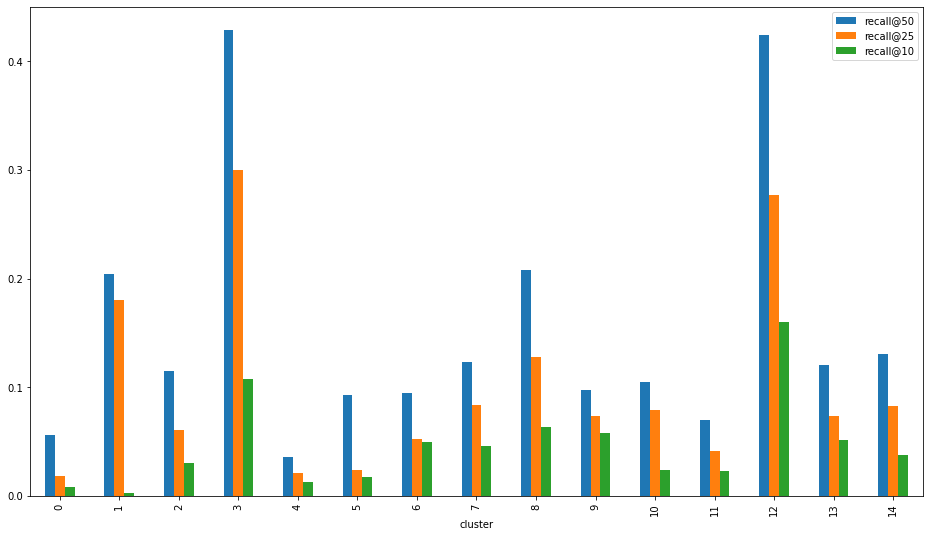

In [ ]:
df_result_all2.groupby('cluster')['recall@50','recall@25','recall@10'].mean().plot.bar(figsize=(16,9))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


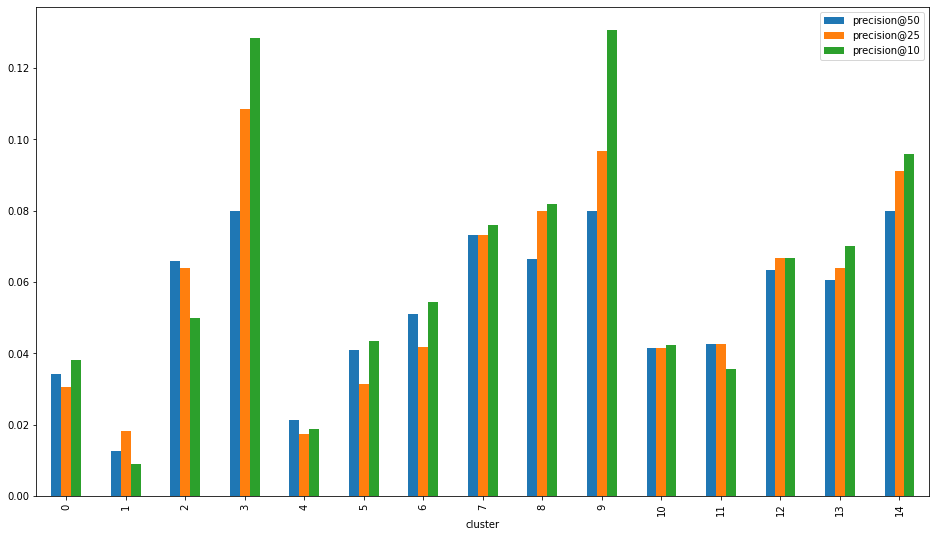

In [ ]:
df_result_all2.groupby('cluster')['precision@50','precision@25','precision@10'].mean().plot.bar(figsize=(16,9))

0.8228486934178312

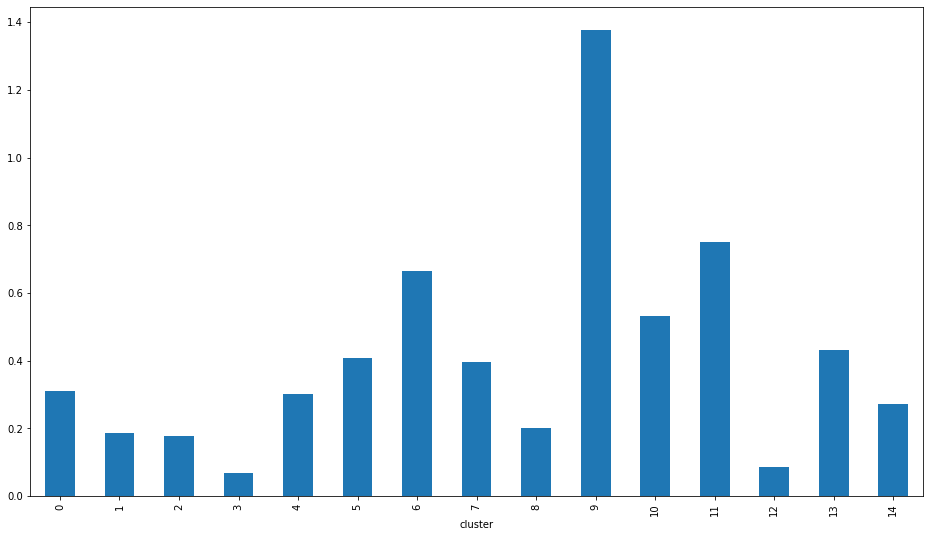

In [ ]:
df_result_all2.groupby('cluster')['spent'].mean().plot.bar(figsize=(16,9))

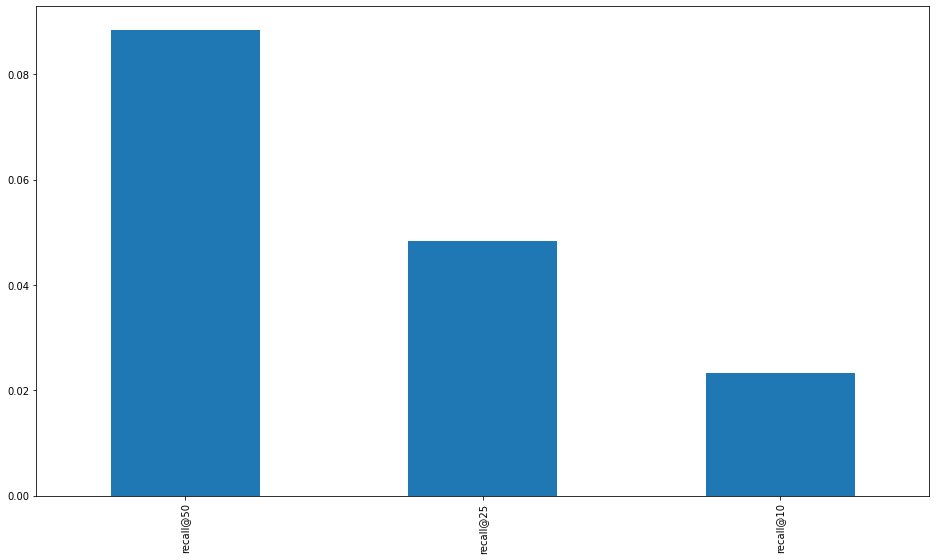

In [ ]:
df_result[['recall@50','recall@25','recall@10']].mean().plot.bar(figsize=(16,9))

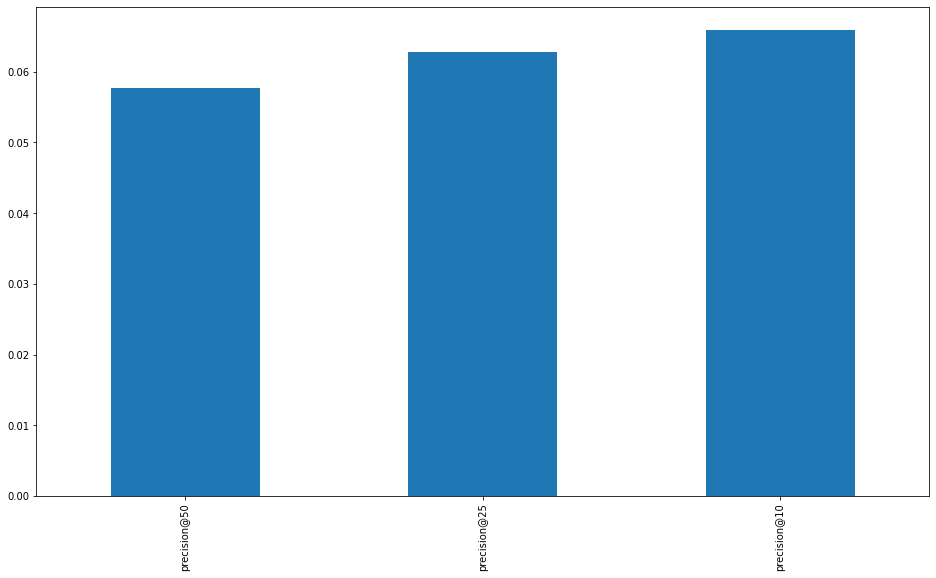

In [ ]:
df_result[['precision@50','precision@25','precision@10']].mean().plot.bar(figsize=(16,9))

In [ ]:
import time

In [ ]:
df_arr = []
for idx in tqdm(range(15)):
    recall_result = []
    precision_result = []
    prediction_result = []

    true_result = []
    correct_result = []
    spent_result = []

    x_test =  test_clusters[idx]
    test_tags = x_test['tag_id'].unique()
    total_songs = np.intersect1d(test_clusters[idx].song_id.unique(), Clusters[idx]._unique_songs)

    k = 50

    for _test_tag_id in tqdm(test_tags):
        song_ids = np.intersect1d(x_test.song_id[x_test.tag_id == _test_tag_id].values, total_songs)

        start_time = time.time()
        predicted = Clusters[idx].predict(idx2tag[_test_tag_id])
        spent_result.append(time.time() - start_time)

        correct_count = np.intersect1d(song_ids, predicted).shape[0]

        correct_result.append(correct_count)
        prediction_result.append(predicted)
        true_result.append(song_ids)

        if len(song_ids) == 0:
          recall_result.append(0)
          precision_result.append(0)
          continue
        
        recall_result.append(correct_count / len(song_ids))
        precision_result.append(correct_count / k)

    tag_names = [idx2tag[tag_id] for tag_id in test_tags]
    df_result = pd.DataFrame([tag_names, recall_result, precision_result, prediction_result, true_result, correct_result, spent_result]).T
    df_result.columns = ['tag', 'recall', 'precision', 'prediction', 'true', 'correct', 'spent']
    df_result['cluster'] = idx
    df_arr.append(df_result)

In [ ]:
df_result_all = pd.concat(df_arr)

In [ ]:
df_result_all.correct

0     6
1     2
2     3
3     2
4     0
     ..
48    0
49    0
50    2
51    0
52    0
Name: correct, Length: 1093, dtype: object

In [ ]:
df_result_all.recall = df_result_all.recall.astype(float)
df_result_all.spent = df_result_all.spent.astype(float)
df_result_all.precision = df_result_all.precision.astype(float)

In [ ]:
df_result_all = df_result_all.reset_index(drop=True)
df_result_all.to_json(get_path('Result_Cluster_v2.json'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


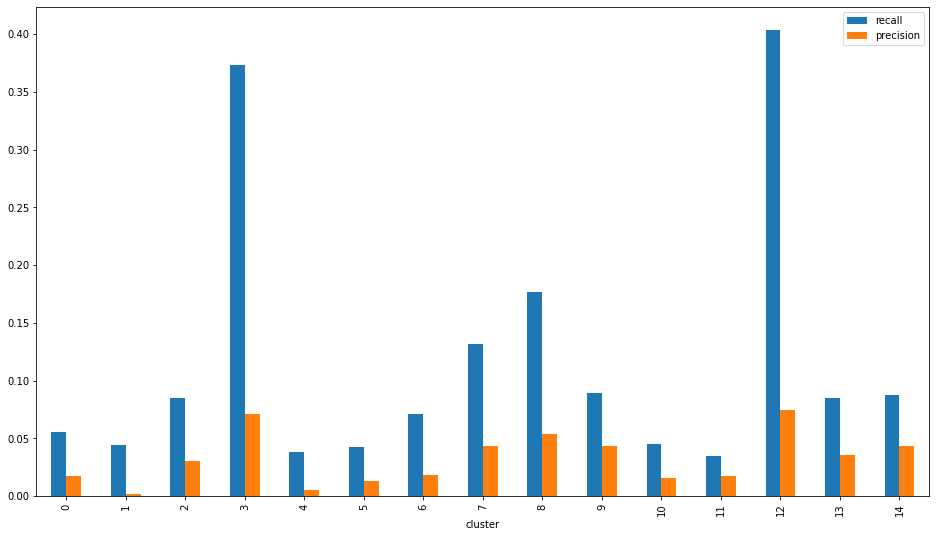

In [ ]:
df_result_all.groupby('cluster')['recall','precision'].mean().plot.bar(figsize=(16,9))

In [ ]:
df_result_all.recall.mean(), df_result_all.precision.mean(), df_result_all.spent.mean()

In [ ]:
good_tags = ['디즈니', '연애', '유재석', '고막남친', '포근한', '연말', '짝사랑', '운전', '봄바람',
       '잠들기전', '힘', '흥겨운', '신곡', '산책', '듣기좋은', '걸그룹', '파티', '비오는날', '추위',
       '비오는', '불토', '재즈', '이브', 'UK', '연애세포', '여행', '가을밤', '센치한', '록',
       '행복', '배경음악', '감성힙합', '추석', '추억', '지친', '집', '어쿠스틱', '감성곡', '드라이브',
       '고속도로', '신나는', '가을비', '트로트', '눈', '불금', '피아노', '발랄', '성인가요', '댄스',
       '주말', '패션', '우울한', '벚꽃', '날씨', '커피', '노동요', '수록곡', '힘내', '경쾌한',
       '정미애', '따뜻함', '노래', 'OfficialCharts', '헤어짐', '남자아이돌', '팝', '댄스곡',
       '정다경', '여유', '휴식', '새벽', '잔잔함', '2000년대', '나른', '우울', '12월',
       '뉴에이지', '우울할때', '명절', '2019년', '중독성', '엄마아리랑', '인디', '비', '자장가',
       '버스', '스타일', '축하', '까페', '퇴근', '2016', '상큼한', '노래방', '찾아오는DJ',
       'RNBSOUL', '상큼', '청량한', 'EDM', 'deep', '한국힙합', '아픔', '밝은', '혼자',
       '기분전환', '찬양', '아이돌', '부드러운', '눈오는날', '귀르가즘', '여름노래', '댄스댄스', 'bar',
       '크리스마스캐롤', '테라스', 'electronica', '연휴', '봄비', '가을', '북카페', '알앤비',
       '토닥토닥', '장마', '트렌디', '꿀잠', '잔잔', '하우스', '와인', '생일', '국외', '고백',
       '신남', '봄노래', '쓸쓸', '얼터너티브', '느낌있는', '성탄절', '브금', '불면증', '귀성길',
       '에이핑크', '디스코', '인기', '달달', '소울', '책읽을때', '슬픔', '운동', '사랑노래', '락',
       '잔잔한노래', '여름밤', '쌀쌀한', '시원한', '저녁', '낮잠', '일렉', '캐롤', '방콕',
       '메리크리스마스', '기분좋은', '따뜻하게', '빌로우', '아무로나미에', '장르구분없이', '월요병', '분위기',
       '청량', '페스티벌', '추천곡', '내적댄스', '국힙', '외로움', '클럽', '즐거운', '맑은', '스포츠',
       '열대야', '오르골', '감성발라드', '밤', '시작', '브릿팝', '산뜻한', 'EDMFloor', '빗소리',
       '쓸쓸함', '조용한', '낙엽', '겨울밤', '좋아요', '2019', '몽환', '블랙뮤직', '겨울노래',
       '겨울', '휴일', '태교', '팝송', '새벽감성', '바캉스', '그리움', '추천', 'Lounge',
       '플레이리스트', 'dance', '달달한', '신나는노래', '하늘', 'Instrumental', '그루브',
       '치유', '봄', '퓨전재즈', '회식', '일렉트로니카', '잔잔한', '힙합엘이', '힙한', '힘들때',
       '설렘', '취향저격', '독서', '썸', '차분', '목소리', '마음', '내한', '랩', '더위', '따듯한',
       '띵곡들', '베스트', '봄나들이', '인디팝', '연주곡', '셋리스트', '감성', '장윤정', '후회',
       '바람', '헬스', '지칠때', '흐린날', '감성적인', '유산슬', '임영웅', '집콕', '에너지',
       '몽환적인', 'Christmas', '해외일렉트로니카', '크리스마스', '바다', '케이팝', '기분업',
       '흥폭발', '겨울감성', '어린이집', '숨은명곡', 'OST', '2000', '고막여친', '춤', '휴가',
       'bgm', '트랩', '연인', '비오는날듣기좋은노래', '하루', '가족', '슬픈', 'Pop', '집중',
       '눈물', '아침', '카페뮤직', '두근두근', 'Rock', '차분한', '출근길', '이별', 'house',
       '기분', '스트레스', '봄날', '잠', 'ballad', '음색', '달콤', '인디음악', '기타',
       '다이어트', '띵곡', '떼창', '오후', '시험', '숙면', '회상', '대세', '캐럴', '취저',
       '달달한노래', '꿀성대', '희망', '팝송모음', '흥', '설레임', '힙합', '애창곡', '카페', '매장',
       '음색깡패', '크리스마스노래', '스웩', '오늘', '음악', '1990', '신나는음악', '유니크', '퇴근길',
       '신나', '잠잘때', '공부', '설날', '힘이_나는', '달콤한', '주제곡', '사랑', '발라드', '생각',
       '여름', '힐링', '여자아이돌', '방탄', '센치', '고백송', '커플', '첫사랑', '조깅', '지하철',
       '위로', '매장음악', '좋은노래', '가사', '데이트', '유산소', '트로피컬', '리드미컬', '솔로',
       '세련된', '비트', '스타일리시', '야경', '나들이', '편안한', '휘트니스', '영국', '일상']

In [ ]:
df_result_all2 = df_result_all[df_result_all.tag.isin(good_tags)].reset_index(drop=True)

In [ ]:
df_result_all.recall.mean(), df_result_all.precision.mean(), df_result_all.spent.mean()

(0.07731164831340281, 0.02417200365965222, 0.3457210925556822)

In [ ]:
df_result_all2.recall.mean(), df_result_all2.precision.mean(), df_result_all2.spent.mean()

(0.12360094823029542, 0.05804469273742998, 0.390558222818641)

In [ ]:
df_result_all2.to_json(get_path('final_result_cluster_v1.json'))

{3: 1.0}

In [ ]:
recall_sum = 0
for i, result in enumerate(df_arr):
  recall_sum += result[1].mean()
  print(f"{i}: {result[1].mean()}")

0: 0.07196991041892681
1: 0.03616850321395775
2: 0.10131510248826124
3: 0.3097004847004847
4: 0.04088337951457655
5: 0.03541757665743019
6: 0.029776676798917674
7: 0.1440690799594905
8: 0.1999840275605478
9: 0.07917766494995254
10: 0.05018722808577115
11: 0.05777204558316362
12: 0.36499944499944503
13: 0.09036851956241895
14: 0.11567236771557138


In [ ]:
df_arr[1].sort_values(1, ascending=0).head(30)

,0,1,2
29,기도,1,0.02
51,취저,1,0.02
43,명절,0.75,0.06
39,감성충전,0.333333,0.02
98,추천음악,0.333333,0.02
64,부모님,0.333333,0.02
21,2016,0.25,0.02
6,자존감,0.166667,0.02
25,좋아요,0.125,0.02
3,보컬,0.0625,0.02


In [ ]:
recall_sum / 15

0.11516413414726107

In [ ]:
%timeit predicted = Clusters[0].predict('성탄절')

1 loop, best of 3: 204 ms per loop


In [ ]:
%timeit predicted = Clusters[1].predict('성탄절')

10 loops, best of 3: 118 ms per loop


In [ ]:
%timeit predicted = Clusters[2].predict('성탄절')

10 loops, best of 3: 111 ms per loop


In [ ]:
%timeit predicted = Clusters[3].predict('성탄절')

10 loops, best of 3: 43.4 ms per loop


In [ ]:
%timeit predicted = Clusters[4].predict('성탄절')

10 loops, best of 3: 192 ms per loop


In [ ]:
%timeit predicted = Clusters[5].predict('성탄절')

1 loop, best of 3: 253 ms per loop


In [ ]:
%timeit predicted = Clusters[6].predict('성탄절')

1 loop, best of 3: 431 ms per loop


In [ ]:
%timeit predicted = Clusters[7].predict('성탄절')

1 loop, best of 3: 261 ms per loop


In [ ]:
%timeit predicted = Clusters[8].predict('성탄절')

10 loops, best of 3: 127 ms per loop


In [ ]:
%timeit predicted = Clusters[9].predict('성탄절')

1 loop, best of 3: 901 ms per loop


In [ ]:
%timeit predicted = Clusters[10].predict('성탄절')

1 loop, best of 3: 338 ms per loop


In [ ]:
%timeit predicted = Clusters[11].predict('성탄절')

1 loop, best of 3: 486 ms per loop


In [ ]:
%timeit predicted = Clusters[12].predict('성탄절')

10 loops, best of 3: 37 ms per loop


In [ ]:
%timeit predicted = Clusters[13].predict('성탄절')

1 loop, best of 3: 281 ms per loop


In [ ]:
%timeit predicted = Clusters[14].predict('성탄절')

10 loops, best of 3: 173 ms per loop


In [ ]:
204+118+111+43.4+192+253+431+261+127+901+338+486+37+281+173

3956.4

In [ ]:
(3956.4) / 15

263.76

In [ ]:
train_tags = train_clusters[0].tag_id.unique()

In [ ]:
df_result['tag_id'] = df_result[0].map(lambda x: tag2idx.get(x))

In [ ]:
df_result.sort_values(2, ascending=False).head(10)

,0,1,2,tag_id
3,아침,0.0228311,0.1,1052
24,시작,0.0689655,0.08,658
5,불금,0.0784314,0.08,215
21,힘내요,0.5,0.08,182
20,일상,0.0307692,0.08,1378
18,힘,0.333333,0.08,53
14,노동요,0.0652174,0.06,242
2,퇴근길,0.026087,0.06,1243
4,고속도로,0.25,0.06,180
7,출근길,0.0178571,0.06,1066


In [ ]:
%time predicted = Clusters[0].predict('불금')

CPU times: user 456 ms, sys: 32.2 ms, total: 488 ms
Wall time: 354 ms


In [ ]:
df_meta[df_meta.id.isin(predicted)]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,gnrs,new_id
1395,['GN1801'],20170106,아침이 밝아올 때,10028806,[1381999],아침이 밝아올 때,['GN1800'],['Morning Dream'],13896,['뉴에이지'],8308
2344,"['GN0702', 'GN0708', 'GN0701']",20190308,Lots of Love,10259010,[418700],오늘 밤에,['GN0700'],['홍진영'],23443,['성인가요'],13946
3145,"['GN1102', 'GN1101']",20150213,Samsara (Feat. Emila) (Single),2305442,[838364],Samsara (Feat. Emila),['GN1100'],['Tungevaag & Raaban'],31529,['일렉트로니카'],18749
3234,"['GN0805', 'GN0509', 'GN0502', 'GN0801', 'GN05...",20160524,When I Begin,2683581,[968452],오늘,"['GN0500', 'GN0800']",['오왠 (O.WHEN)'],32385,"['인디음악', '포크/블루스']",19237
4300,"['GN1102', 'GN1101']",20160805,Encore,2645246,[195400],Let Me Love You (Feat. Justin Bieber),['GN1100'],['DJ Snake'],43627,['일렉트로니카'],25777
5463,['GN2601'],20180517,MEGA DRIVE,10167508,[959785],MEGA DRIVE,['GN2600'],['COLOR LOUNGE'],55570,['일렉트로니카'],32479
7654,"['GN2502', 'GN2501', 'GN0303', 'GN2504', 'GN03...",20151116,WELCOME BACK,2640151,[895741],취향저격,"['GN2500', 'GN0300']",['iKON'],78180,"['아이돌', '랩/힙합']",43590
13653,"['GN0105', 'GN1501', 'GN0101', 'GN1504']",20110804,공주의 남자 OST Part.3,2006804,"[43806, 39256]",기다릴게,"['GN1500', 'GN0100']","['하동균', 'J.Lee']",138586,"['OST', '발라드']",4484
14179,"['GN0501', 'GN0101', 'GN0506', 'GN0509']",20110517,Kim Ji Soo 1st Mini Album,1270457,[8806],Chocolate Drive,"['GN0500', 'GN0100']",['김지수'],143718,"['인디음악', '발라드']",7592
14343,"['GN0101', 'GN0102']",19880201,나 항상 그대를,326844,[966],나 항상 그대를,['GN0100'],['이선희'],145390,['발라드'],8559
